# JupyerLab notebook example for PFAS related simulations

## Module imports

In [1]:
# External modules (to "pip install")
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import interp1d  # type: ignore[import]

# Modules from Standard lib
from pathlib import Path
import re

# RadioBio module
import radiopyo as rp
from daub.radiopyo.rdb import RadioPyDB
from daub.radiopyo import pw_model as pwm
from daub.radiopyo.rdf import RadioPyHDF
db = RadioPyDB.from_folder(r"D:\DATA\PFAS")

In [2]:
from Plot_template import RPlot, FigManager
RPlot.init_rcparams()
fig_man = FigManager()

# Load litterature Results

In [3]:
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\data_litterature")
litt = {}
regex = re.compile("dose_VS_(?P<label>\w+)_(?P<ppm>\d+)ppm.csv")
for elt in root.glob("*.csv"):
    _ = regex.match(elt.name)
    key = int(_.group("ppm"))
    label = _.group("label")
    _ = pd.read_csv(elt, header=0, index_col=0)
    if key not in litt:
        litt[key] = pd.DataFrame(index=_.index*1e3, data=_.iloc[:,0].values*1e3, columns=[label])
        continue
    interp = interp1d(x=_.index*1e3,
                      y=_.iloc[:,0].values*1e3,
                     kind="quadratic",
                     fill_value="extrapolate")
    litt[key][label] = interp(litt[key].index.values)
    

## Simulation Run

**1) Load configuration from the toml file +**  
 -> create a ref to O2 species for later use  
 -> define the desired number of pulses  
 -> define the period

**2) Run sim over the first pulse**

In [2]:
file = Path(rf"configuration_PFAS.toml")
#file = Path(r"configuration_PFAS_basic.toml")
uc = rp.UnitCell.from_toml(file)


2023-07-26 15:43:59,472::radiopyo::INFO::Loading config from file: configuration_PFAS.toml
2023-07-26 15:43:59,492::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-07-26 15:43:59,727::radiopyo::INFO::File is loaded
2023-07-26 15:43:59,728::radiopyo::INFO::Beam configuration detected in config file
2023-07-26 15:43:59,728::radiopyo::INFO::BEAM:: Assigning 'default' name to beam definition constant -> {'dose_rate': 1580.0, 'max_dose': 2000000.0, 'start_time': 0.0, 'LET': 0.17}
2023-07-26 15:43:59,730::radiopyo::INFO::CONFIG::Configuring Simulation Environment
2023-07-26 15:43:59,731::radiopyo::INFO::CONFIG::3 Acid/Base reactions added
2023-07-26 15:44:00,016::radiopyo::INFO::CONFIG::28 K-reactions added
2023-07-26 15:44:00,017::radiopyo::INFO::CONFIG::0 Enzymatic reactions added
2023-07-26 15:44:00,018::radiopyo::INFO::CONFIG::5 Radiolytic reactions added
2023-07-26 15:44:00,019::radiopyo::INFO::CONFIG::15 Dynamical 

In [3]:
uc.beam_list.current_LET

0.17

In [3]:
file = Path(rf"configuration_PFAS.toml")
#file = Path(r"configuration_PFAS_basic.toml")
uc = rp.UnitCell.from_toml(file)

all_res_2 = []

stock_res = all_res_2
for dose in np.linspace(2000e3, 0, num=21):
    if dose <= 0.0:
        dose = 0.01
    #dose = 1500e3
    uc.set_beam(rp.physics.beam.ConstantBeam(dose_rate=uc.beam_list.current.dose_rate, max_dose=dose))
    res = uc.run_till_max_dose(atol=1e-4, rtol=1e-1, method="LSODA", max_step=0.05, use_jac=False)
    break
    #db.insert_ODEResult(res, project="fixed_Dr_100mg_eaq_eaq")
    stock_res.append(res)

2023-07-26 16:00:00,658::radiopyo::INFO::Loading config from file: configuration_PFAS.toml
2023-07-26 16:00:00,666::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-07-26 16:00:00,931::radiopyo::INFO::File is loaded
2023-07-26 16:00:00,931::radiopyo::INFO::Beam configuration detected in config file
2023-07-26 16:00:00,932::radiopyo::INFO::BEAM:: Assigning 'default' name to beam definition constant -> {'dose_rate': 1580.0, 'max_dose': 2000000.0, 'start_time': 0.0, 'LET': 0.17}
2023-07-26 16:00:00,933::radiopyo::INFO::CONFIG::Configuring Simulation Environment
2023-07-26 16:00:00,933::radiopyo::INFO::CONFIG::3 Acid/Base reactions added
2023-07-26 16:00:01,124::radiopyo::INFO::CONFIG::28 K-reactions added
2023-07-26 16:00:01,125::radiopyo::INFO::CONFIG::0 Enzymatic reactions added
2023-07-26 16:00:01,126::radiopyo::INFO::CONFIG::5 Radiolytic reactions added
2023-07-26 16:00:01,126::radiopyo::INFO::CONFIG::15 Dynamical 

**Convert final result to pandas DataFrame**

In [4]:
df = res.to_pandas()

## Results usage

### Plot

In [5]:
# Some common plot options for uniformity
RIGHT_LIMIT = 1500

#### Water-only Radiolytic produced species

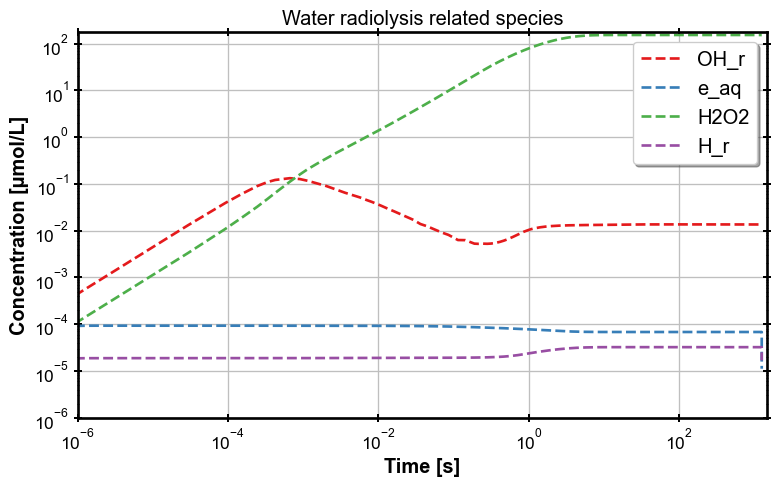

In [6]:
G_species = ["OH_r", "e_aq", "H2O2", "H_r"]
with fig_man.open(f"Radiolysis") as (fig, ax):
    for label in G_species:
        ax.plot(df.index, df[label], label=label, marker="")

    ax.set_ylim(bottom=1e-6)
    ax.set_xlim([1e-6, RIGHT_LIMIT])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Water radiolysis related species")


#### PFAS species

In [7]:
df

,OH_r,O_r_minus,H2O2,HO2_minus,HO2_r,O2_r_minus,e_aq,H_r,H2,O2_minus_minus,O3_minus,C7F15COO_minus,C7F15COO_r_minus_minus,C8F17SO3_minus,C8F17SO3_r_minus_minus
1.000000e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,24.200000,0.000000e+00,20.000000,0.000000e+00
1.001000e-09,4.440977e-10,5.590859e-15,1.121959e-10,2.238603e-15,2.061533e-17,2.595316e-15,4.421265e-10,9.825339e-11,7.134749e-11,1.491702e-32,5.031773e-21,24.200000,5.456725e-19,20.000000,4.509690e-19
1.002000e-09,8.881954e-10,1.118172e-14,2.243919e-10,4.477207e-15,6.184588e-17,7.785935e-15,8.842509e-10,1.965063e-10,1.426950e-10,1.044185e-31,1.509532e-20,24.200000,1.637015e-18,20.000000,1.352905e-18
1.100200e-08,4.441868e-06,5.591980e-11,1.122184e-06,2.239051e-11,1.006784e-09,1.267466e-07,4.319440e-06,9.576610e-07,7.136202e-07,3.556485e-17,2.516894e-13,24.200000,2.666109e-11,20.000000,2.203396e-11
2.100200e-08,8.882852e-06,1.118285e-10,2.244143e-06,4.477655e-11,3.978657e-09,5.008833e-07,8.437390e-06,1.866276e-06,1.427103e-06,3.457512e-16,1.006557e-12,24.200000,1.053846e-10,20.000000,8.709469e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.265823e+03,1.355692e-02,1.706716e-07,1.528209e+02,3.049178e-03,3.553250e-02,4.473276e+00,6.809339e-05,3.226111e-05,1.253363e+02,5.014000e+03,1.945232e+02,0.297996,2.390200e+01,0.246278,1.975372e+01
1.265823e+03,1.355692e-02,1.706716e-07,1.528209e+02,3.049178e-03,3.553250e-02,4.473276e+00,6.809339e-05,3.226111e-05,1.253363e+02,5.014000e+03,1.945232e+02,0.297996,2.390200e+01,0.246277,1.975372e+01
1.265823e+03,1.355692e-02,1.706716e-07,1.528209e+02,3.049178e-03,3.553250e-02,4.473276e+00,6.809339e-05,3.226111e-05,1.253363e+02,5.014000e+03,1.945232e+02,0.297996,2.390200e+01,0.246277,1.975372e+01
1.265823e+03,1.355692e-02,1.706716e-07,1.528209e+02,3.049178e-03,3.553250e-02,4.473276e+00,6.809339e-05,3.226111e-05,1.253363e+02,5.014001e+03,1.945232e+02,0.297996,2.390200e+01,0.246277,1.975372e+01


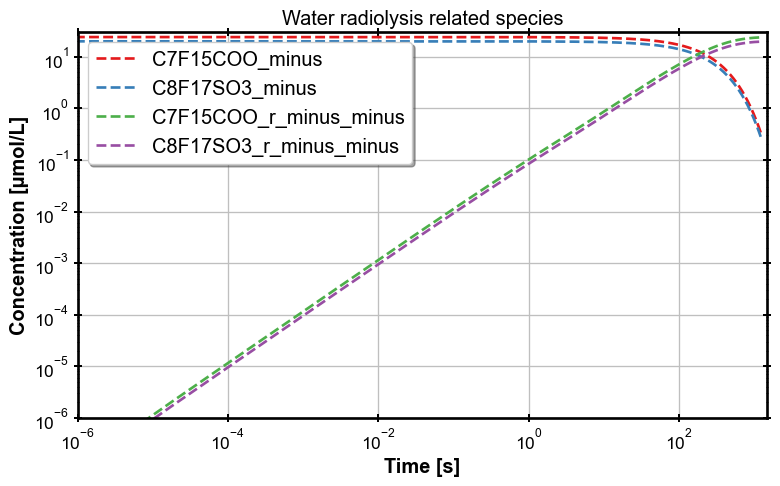

In [8]:
G_species = ["C7F15COO_minus", "C8F17SO3_minus", "C7F15COO_r_minus_minus", "C8F17SO3_r_minus_minus"]
with fig_man.open(f"PFAS Species") as (fig, ax):
    for label in G_species:
        ax.plot(df.index, df[label], label=label, marker="")

    ax.set_ylim(bottom=1e-6)
    ax.set_xlim([1e-6, RIGHT_LIMIT])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/L]")
    ax.legend(fancybox=True, framealpha=1)
    ax.set_title("Water radiolysis related species")


In [12]:
ares = all_res_2
doses = [res.beam.max_dose for res in ares]
species = ["C7F15COO_minus", "C8F17SO3_minus"]
df = pd.DataFrame(index=doses, columns=species)
for idx, sim in enumerate(ares):
    for elt in species:
        df.loc[sim.beam.max_dose, elt] = sim[elt].iloc[-1]

In [13]:
litt[100]

,PFOS
X,
0.000000e+00,200.110375
9.906292e+04,160.375276
2.971888e+05,116.225166
6.024096e+05,86.203091
9.022758e+05,76.490066
1.502008e+06,72.075055
2.000000e+06,70.309051


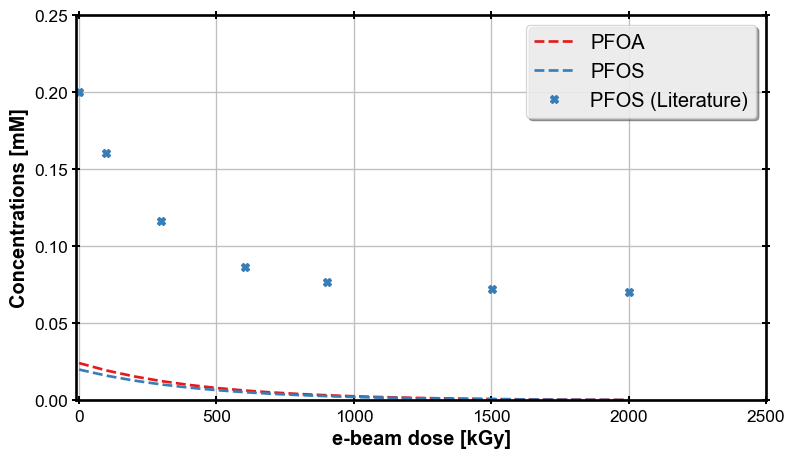

In [14]:
with fig_man.open("PFAS cc evolution with max dose") as (fig, ax):
    for elt in df:
        label = "PFOA" if elt.startswith("C7F15") else "PFOS"
        l, =ax.plot(df.index/1e3, df[elt]/1e3, label=f"{label}", marker="")
        if label == "PFOS":
            ax.plot(litt[100].index/1e3, litt[100][label]/1e3, label=f"{label} (Literature)", linestyle="", color=l.get_color())
        
    ax.legend()
    ax.set_xlim(left=-10)
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xlabel("e-beam dose [kGy]")
    ax.set_ylabel("Concentrations [mM]")
fig.savefig(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\WEEKLY\20230629_W26\dose_VS_cc_100ppm.png", transparent=True)

In [15]:
ares = all_res_2
doses = [res.beam.max_dose for res in ares]
species = ["C7F15COO_minus", "C8F17SO3_minus"]
df = pd.DataFrame(index=doses, columns=species)
for idx, sim in enumerate(ares):
    for elt in species:
        df.loc[sim.beam.max_dose, elt] = sim[elt].iloc[-1]

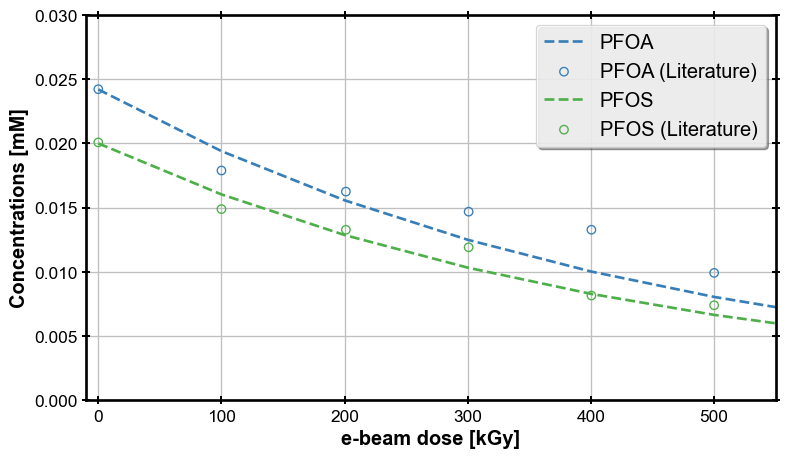

In [18]:
with fig_man.open("PFAS cc evolution with max dose 10 pmm") as (fig, ax):
    RPlot.jump_color(ax, 1)
    for elt in df:
        label = "PFOA" if elt.startswith("C7F15") else "PFOS"
        l, =ax.plot(df.index/1e3, df[elt]/1e3, label=f"{label}", marker="")
        ax.scatter(litt[10].index/1e3, litt[10][label]/1e3,
                   s=40,
                   label=f"{label} (Literature)",
                   linestyle="",
                   edgecolors=l.get_color(),
                   facecolors='none',
                   zorder=10)
        
    ax.legend()
    ax.set_xlim(left=-10, right=550)
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xlabel("e-beam dose [kGy]")
    ax.set_ylabel("Concentrations [mM]")
fig.savefig(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\WEEKLY\20230629_W26\dose_VS_cc_10ppm.png", transparent=True)

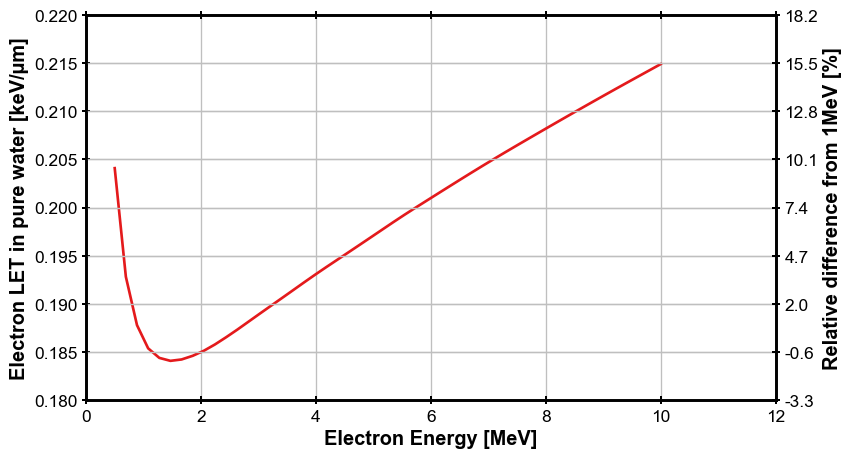

In [137]:
from radiopyo.input.e_LET import EnergyLET
LET = EnergyLET()

with fig_man.open("Electron Energy LET") as (fig, ax):
    x_val = np.linspace(0.5, 10)
    y_val = LET.values_at(x_val)
    ax.plot(x_val, y_val, marker="", linestyle="-")
    ax.set_xlabel("Electron Energy [MeV]")
    ax.set_ylabel("Electron LET in pure water [keV/µm]")
    
    ax2 = ax.twinx()
    y_lim = np.array(ax.get_ylim())
    ax2.set_ylim((y_lim-0.1862)/0.1862*100)
    RPlot.adapt_yticks(ax, ax2)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax2.set_ylabel("Relative difference from 1MeV [%]")
fig.savefig(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\EPT\WEEKLY\20230629_W26\electron_LET.png", transparent=True)
val = LET.values_at([1, 6, 8, 30])

In [138]:
val

array([0.1862, 0.201 , 0.2082, 0.2738])

## Reaction rates

### High dose

In [9]:
res["C7F15COO_minus"]

1.000000e-09    24.200000
1.001000e-09    24.200000
1.002000e-09    24.200000
1.100200e-08    24.200000
2.100200e-08    24.200000
                  ...    
1.265771e+03    22.084795
1.265821e+03    22.084777
1.265822e+03    22.084777
1.265822e+03    22.084777
1.265823e+03    22.084776
Length: 25368, dtype: float64

In [18]:
file = Path(rf"configuration_PFAS.toml")
#file = Path(r"configuration_PFAS_basic.toml")
uc = rp.UnitCell.from_toml(file)

#uc.use_acid_base(False)
uc.set_beam(rp.physics.beam.ConstantBeam(dose_rate=uc.beam.dose_rate, max_dose=2000e3))
res2 = uc.run_till_max_dose(atol=1e-4, rtol=1e-1, method="LSODA", max_step=0.05)
df2 = res.reconstruct_reactions()

2023-06-30 08:09:23,879::radiopyo::INFO::Loading config from file: configuration_PFAS.toml
2023-06-30 08:09:23,883::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-06-30 08:09:23,887::radiopyo::INFO::File is loaded
2023-06-30 08:09:23,888::radiopyo::INFO::Beam configuration detected in config file
2023-06-30 08:09:23,889::radiopyo::INFO::Beam ConstantBeam(dose_rate=1.6e+03, max_dose=2000000.0) is setup
2023-06-30 08:09:23,889::radiopyo::INFO::CONFIG::Configuring Simulation Environment
2023-06-30 08:09:23,890::radiopyo::INFO::CONFIG::3 Acid/Base reactions added
2023-06-30 08:09:23,891::radiopyo::INFO::CONFIG::28 K-reactions added
2023-06-30 08:09:23,891::radiopyo::INFO::CONFIG::0 Enzymatic reactions added
2023-06-30 08:09:23,892::radiopyo::INFO::CONFIG::5 Radiolytic reactions added
2023-06-30 08:09:23,893::radiopyo::INFO::CONFIG::15 Dynamical Species added.
2023-06-30 08:09:23,893::radiopyo::INFO::CONFIG::4 Constant

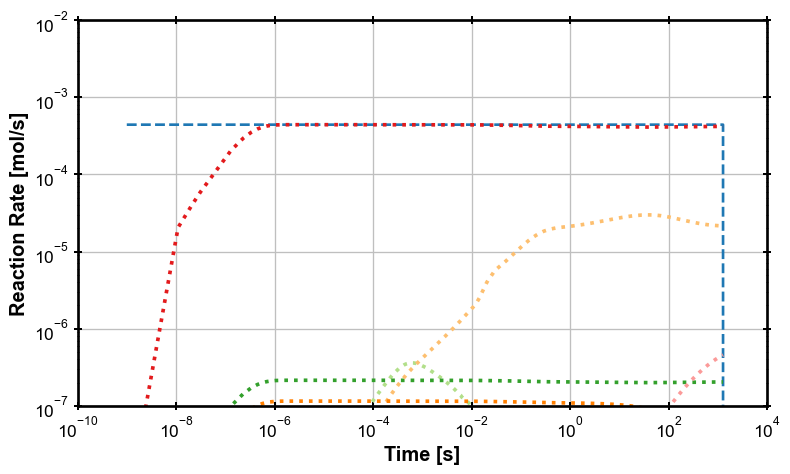

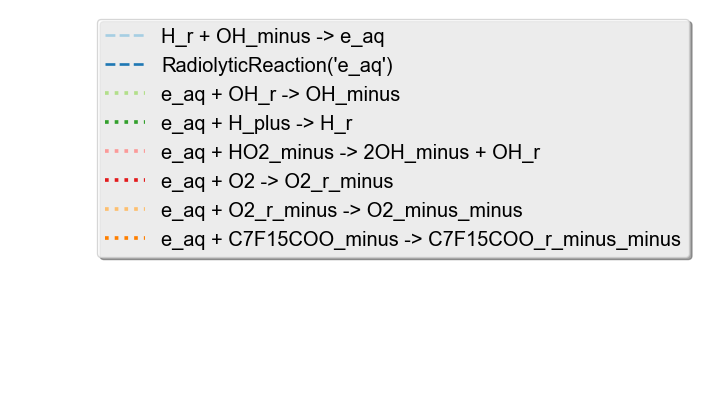

In [11]:
fig_man.set_brewer_map("Paired", "qualitative", 8)
with fig_man.open("Reactions with e_aq") as (fig, ax):
    for reaction in res.env.reactions_involving_product("e_aq"):
        ax.plot(df.index, df[reaction.as_label()],
                label=str(reaction),
                marker="")
    for reaction in res.env.reactions_involving_reactant("e_aq"):
        if df[reaction.as_label()].max() < 1e-7:
            continue
        ax.plot(df.index, df[reaction.as_label()],
                label=str(reaction),
                marker="",
                linestyle=":",
                linewidth=2.75)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-7)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [mol/s]")

fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels())#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
#fig_l.set_size_inches(bbox.width, bbox.height)
#fig_l.tight_layout()
    
    
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS")
#fig.savefig(root/"Reactions_e_aq_10ppm_2000kGy.png")
#fig_l.savefig(root/"Reactions_e_aq_10ppm_legend_2000kGy.png", bbox_inches=bbox.expanded(1.02,1.04), transparent=True)

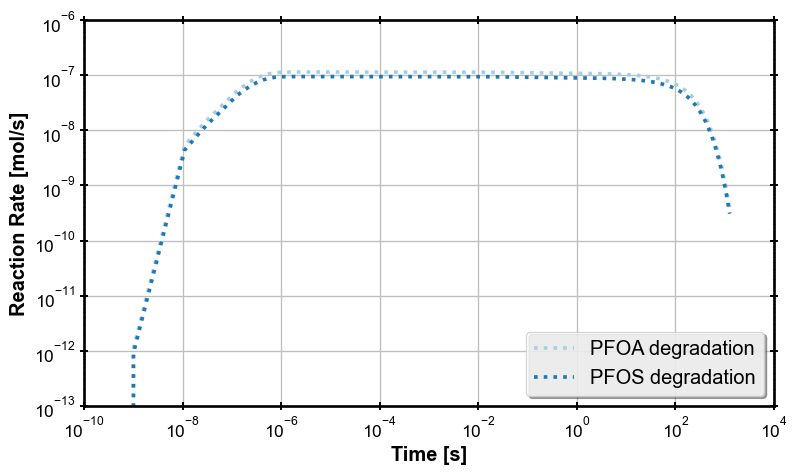

In [12]:
fig_man.set_brewer_map("Paired", "qualitative", 8)
with fig_man.open("Reactions with C7F15COO_minus") as (fig, ax):
    for reaction in res.env.reactions_involving_reactant("C7F15COO_minus"):
        ax.plot(df.index, df[reaction.as_label()],
                label="PFOA degradation",
                marker="",
                linestyle=":",
                linewidth=2.75)
    for reaction in res.env.reactions_involving_reactant("C8F17SO3_minus"):
        ax.plot(df.index, df[reaction.as_label()],
                label="PFOS degradation",
                marker="",
                linestyle=":",
                linewidth=2.75) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [mol/s]")
    ax.legend()
    
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS")
#fig.savefig(root/"PFAS_degradation_rrate_2000kGy.png", transparent=True)


In [ ]:
for sp in ["C7F15COO_minus", "C8F17SO3_minus"]:

In [27]:
res.env.initial_cc

{'C7F15COO_minus': 2.42e-05, 'C8F17SO3_minus': 2e-05}

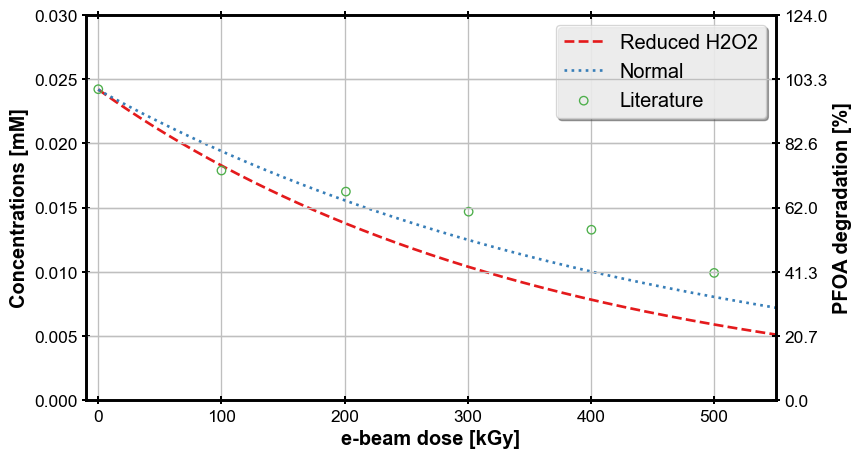

Normal:  9.65855005438743
Reduced H2O2:  5.9073006794544485
38.83863886204082


In [55]:
fig_man.set_brewer_map("Set1", "qualitative", 3)
with fig_man.open("PFAS cc evolution with max dose 10 pmm, reduced H2O2") as (fig, ax):
    sp = "C7F15COO_minus"
    label = "PFOA" if sp.startswith("C7F15") else "PFOS"
    ax.plot(res.t/1e3*res.beam.dose_rate, res[sp]/1e3, label=f"Reduced H2O2", marker="")
    ax.plot(res2.t/1e3*res2.beam.dose_rate, res2[sp]/1e3, label=f"Normal", marker="", linestyle=":")
    
    l, = ax.plot([],[])
    ax.scatter(litt[10].index/1e3, litt[10][label]/1e3,
               s=40,
               label=f"Literature",
               linestyle="",
               edgecolors=l.get_color(),
               facecolors='none',
               zorder=10)
        
    ax.legend()
    ax.set_xlim(left=-10, right=550)
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xlabel("e-beam dose [kGy]")
    ax.set_ylabel("Concentrations [mM]")
    ax2 = ax.twinx()
    lim = np.array(ax.get_ylim())
    ax2.set_ylim(lim/(res.env.initial_cc[sp]*1e3)*100)
    RPlot.adapt_yticks(ax, ax2)
    ax2.set_ylabel(f"{label} degradation [%]")
    
fig.savefig(rf"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS\{label}_VS_dose_10ppm_no_H2O2.png", transparent=True)

idx = (np.abs(res.t - (500e3/res.beam.dose_rate))).argmin()
idx2 = (np.abs(res2.t - (500e3/res2.beam.dose_rate))).argmin()
print("Normal: ", res2[sp].iloc[idx])
print("Reduced H2O2: ", res[sp].iloc[idx])
print((res2[sp].iloc[idx]-res[sp].iloc[idx])/res2[sp].iloc[idx]*100)

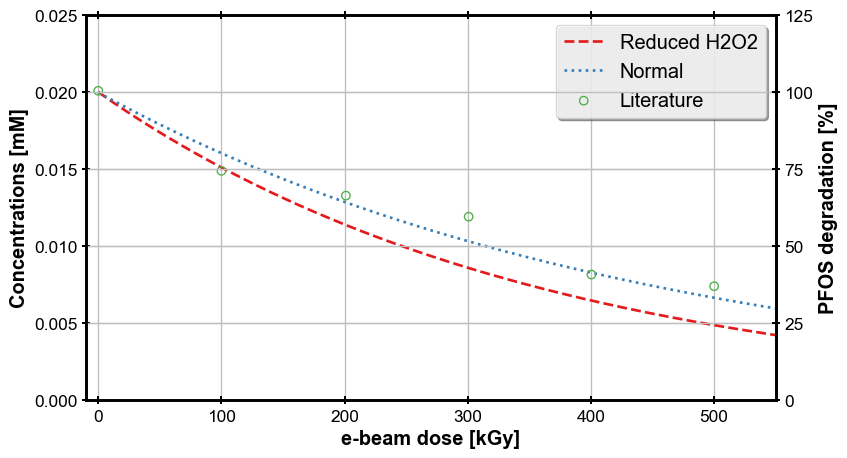

Normal:  7.982272772221054
Reduced H2O2:  4.88206667723502
38.83863886204188


In [56]:
fig_man.set_brewer_map("Set1", "qualitative", 3)
with fig_man.open("PFOS cc evolution with max dose 10 pmm, reduced H2O2") as (fig, ax):
    sp = "C8F17SO3_minus"
    label = "PFOA" if sp.startswith("C7F15") else "PFOS"
    ax.plot(res.t/1e3*res.beam.dose_rate, res[sp]/1e3, label=f"Reduced H2O2", marker="")
    ax.plot(res2.t/1e3*res2.beam.dose_rate, res2[sp]/1e3, label=f"Normal", marker="", linestyle=":")
    
    l, = ax.plot([],[])
    ax.scatter(litt[10].index/1e3, litt[10][label]/1e3,
               s=40,
               label=f"Literature",
               linestyle="",
               edgecolors=l.get_color(),
               facecolors='none',
               zorder=10)
        
    ax.legend()
    ax.set_xlim(left=-10, right=550)
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xlabel("e-beam dose [kGy]")
    ax.set_ylabel("Concentrations [mM]")
    ax2 = ax.twinx()
    lim = np.array(ax.get_ylim())
    ax2.set_ylim(lim/(res.env.initial_cc[sp]*1e3)*100)
    RPlot.adapt_yticks(ax, ax2)
    ax2.set_ylabel(f"{label} degradation [%]")
    
fig.savefig(rf"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS\{label}_VS_dose_10ppm_no_H2O2.png", transparent=True)

idx = (np.abs(res.t - (500e3/res.beam.dose_rate))).argmin()
idx2 = (np.abs(res2.t - (500e3/res2.beam.dose_rate))).argmin()
print("Normal: ", res2[sp].iloc[idx])
print("Reduced H2O2: ", res[sp].iloc[idx])
print((res2[sp].iloc[idx]-res[sp].iloc[idx])/res2[sp].iloc[idx]*100)

316.45569620253167

In [53]:
idx = (np.abs(res.t - (500e3/res.beam.dose_rate))).argmin()
res.t[idx]

500014.63074426923

## H2O2 reactions

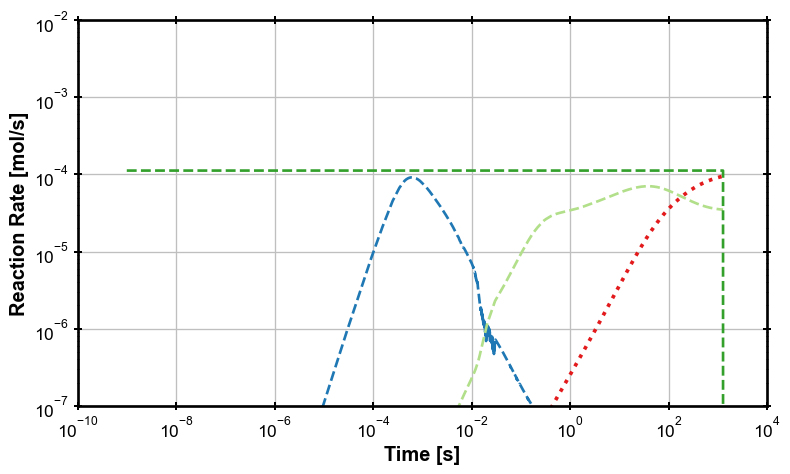

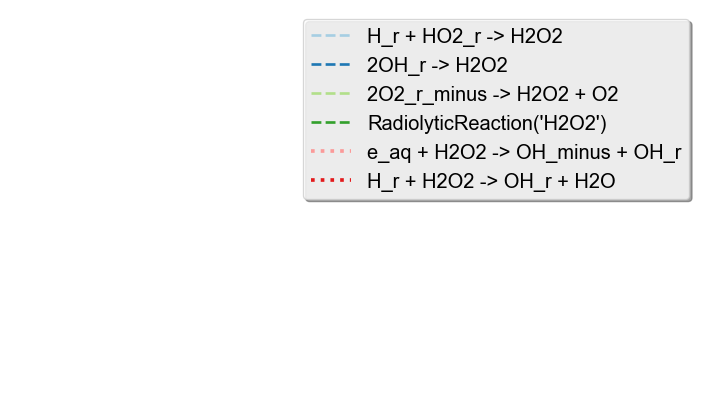

In [13]:
fig_man.set_brewer_map("Paired", "qualitative", 8)
with fig_man.open("Reactions with H2O2") as (fig, ax):
    for reaction in res.env.reactions_involving_product("H2O2"):
        ax.plot(df.index, df[reaction.as_label()],
                label=str(reaction),
                marker="")
    for reaction in res.env.reactions_involving_reactant("H2O2"):
        ax.plot(df.index, df[reaction.as_label()],
                label=str(reaction),
                marker="",
                linestyle=":",
                linewidth=2.75)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-7)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [mol/s]")

fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels())#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
#fig_l.set_size_inches(bbox.width, bbox.height)
#fig_l.tight_layout()
    
    
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS")
#fig.savefig(root/"Reactions_H2O2_10ppm_2000kGy.png", transparent=True)
#fig_l.savefig(root/"Reactions_H2O2_10ppm_legend_2000kGy.png", bbox_inches=bbox.expanded(1.02,1.04), transparent=True)

### Low dose simulation

In [209]:
file = Path(rf"configuration_PFAS.toml")
#file = Path(r"configuration_PFAS_basic.toml")
uc = rp.UnitCell.from_toml(file)

uc.set_beam(rp.physics.beam.ConstantBeam(dose_rate=uc.beam.dose_rate, max_dose=400e3))
res_l = uc.run_till_max_dose(atol=1e-4, rtol=1e-1, method="LSODA", max_step=0.05)
dfl = res.reconstruct_reactions()

2023-06-28 17:42:31,101::radiopyo::INFO::Loading config from file: configuration_PFAS.toml
2023-06-28 17:42:31,104::radiopyo::INFO::Resolving include: C:\Users\rtonneau\DEV\PYTHON\radiopyo\radiopyo\data\basic_water_radiolysis.toml
2023-06-28 17:42:31,111::radiopyo::INFO::File is loaded
2023-06-28 17:42:31,111::radiopyo::INFO::Beam configuration detected in config file
2023-06-28 17:42:31,112::radiopyo::INFO::Beam ConstantBeam(dose_rate=1.6e+03, max_dose=2000000.0) is setup
2023-06-28 17:42:31,113::radiopyo::INFO::CONFIG::Configuring Simulation Environment
2023-06-28 17:42:31,114::radiopyo::INFO::CONFIG::3 Acid/Base reactions added
2023-06-28 17:42:31,114::radiopyo::INFO::CONFIG::28 K-reactions added
2023-06-28 17:42:31,115::radiopyo::INFO::CONFIG::0 Enzymatic reactions added
2023-06-28 17:42:31,116::radiopyo::INFO::CONFIG::5 Radiolytic reactions added
2023-06-28 17:42:31,117::radiopyo::INFO::CONFIG::15 Dynamical Species added.
2023-06-28 17:42:31,118::radiopyo::INFO::CONFIG::4 Constant

In [212]:
dfl = res_l.reconstruct_reactions()

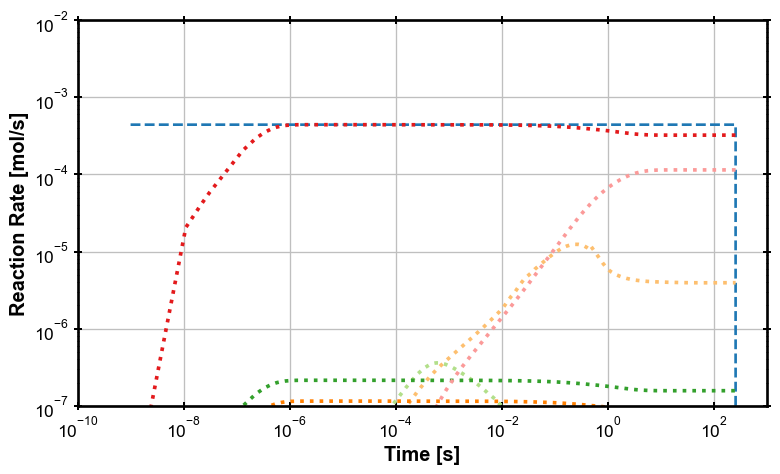

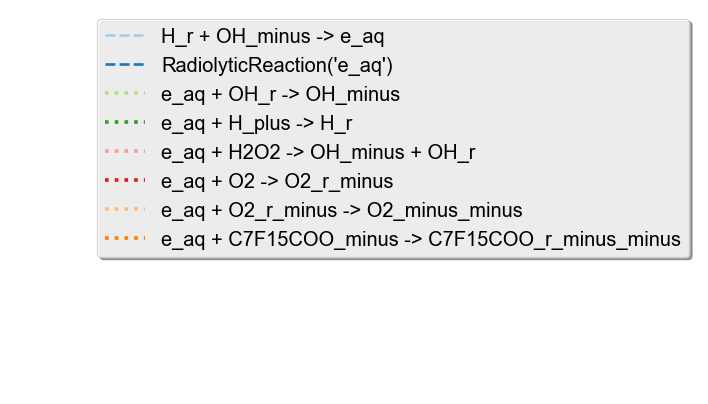

In [223]:
fig_man.set_brewer_map("Paired", "qualitative", 8)
with fig_man.open("Reactions with e_aq") as (fig, ax):
    for reaction in res_l.env.reactions_involving_product("e_aq"):
        ax.plot(dfl.index, dfl[reaction.as_label()],
                label=str(reaction),
                marker="")
    for reaction in res_l.env.reactions_involving_reactant("e_aq"):
        if dfl[reaction.as_label()].max() < 1e-7:
            continue
        ax.plot(dfl.index, dfl[reaction.as_label()],
                label=str(reaction),
                marker="",
                linestyle=":",
                linewidth=2.75)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-7)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [mol/s]")

fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels())#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
#fig_l.set_size_inches(bbox.width, bbox.height)
#fig_l.tight_layout()
    
    
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS")
fig.savefig(root/"Reactions_e_aq_10ppm_400kGy.png", transparent=True)
fig_l.savefig(root/"Reactions_e_aq_10ppm_legend_400kGy.png", bbox_inches=bbox.expanded(1.02,1.04), transparent=True)

## H2O2 reactions

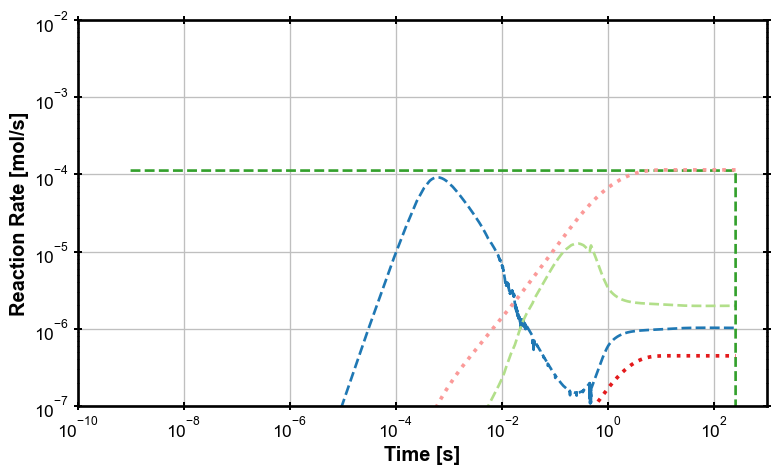

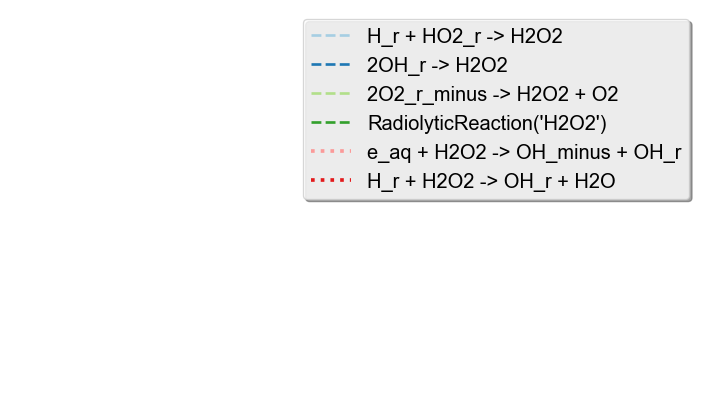

In [234]:
fig_man.set_brewer_map("Paired", "qualitative", 8)
with fig_man.open("Reactions with H2O2") as (fig, ax):
    for reaction in res_l.env.reactions_involving_product("H2O2"):
        ax.plot(dfl.index, dfl[reaction.as_label()],
                label=str(reaction),
                marker="")
    for reaction in res_l.env.reactions_involving_reactant("H2O2"):
        if dfl[reaction.as_label()].max() < 1e-7:
            continue
        ax.plot(dfl.index, dfl[reaction.as_label()],
                label=str(reaction),
                marker="",
                linestyle=":",
                linewidth=2.75)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-7)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [mol/s]")

fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels())#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
#fig_l.set_size_inches(bbox.width, bbox.height)
#fig_l.tight_layout()
    
    
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS")
fig.savefig(root/"Reactions_H2O2_10ppm_400kGy.png", transparent=True)
fig_l.savefig(root/"Reactions_H2O2_10ppm_legend_400kGy.png", bbox_inches=bbox.expanded(1.02,1.04), transparent=True)

## OH_r reactions

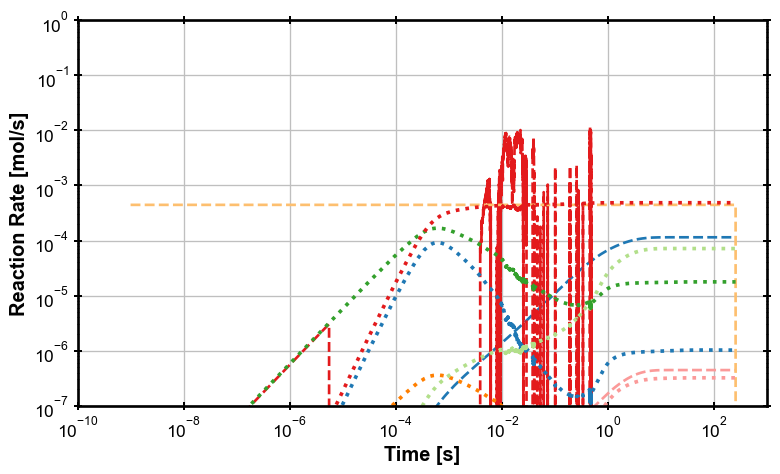

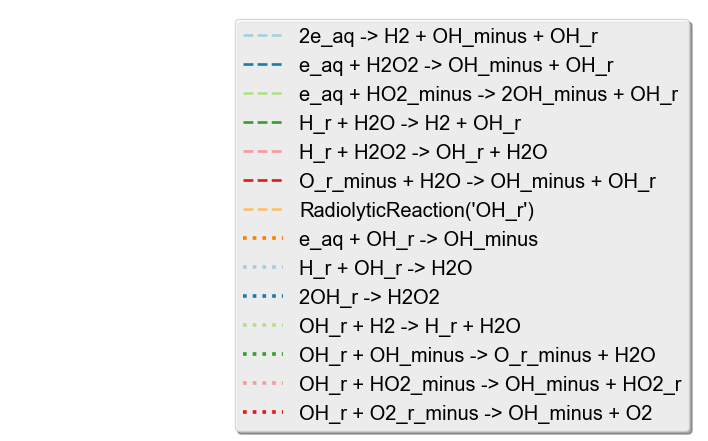

In [236]:
fig_man.set_brewer_map("Paired", "qualitative", 8)
with fig_man.open("Reactions with OH_r") as (fig, ax):
    for reaction in res_l.env.reactions_involving_product("OH_r"):
        ax.plot(dfl.index, dfl[reaction.as_label()],
                label=str(reaction),
                marker="")
    for reaction in res_l.env.reactions_involving_reactant("OH_r"):
        ax.plot(dfl.index, dfl[reaction.as_label()],
                label=str(reaction),
                marker="",
                linestyle=":",
                linewidth=2.75)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-7)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [mol/s]")

fig_l, ax_l = plt.subplots()
ax_l.axis("off")
legend = ax_l.legend(*ax.get_legend_handles_labels())#, bbox_to_anchor=(-0.0, -0.0))
fig_l.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig_l.dpi_scale_trans.inverted())
#fig_l.set_size_inches(bbox.width, bbox.height)
#fig_l.tight_layout()
    
    
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS")
fig.savefig(root/"Reactions_OH_r_10ppm_400kGy.png", transparent=True)
fig_l.savefig(root/"Reactions_OH_r_10ppm_legend_400kGy.png", bbox_inches=bbox.expanded(1.02,1.04), transparent=True)

## PFOA degradation

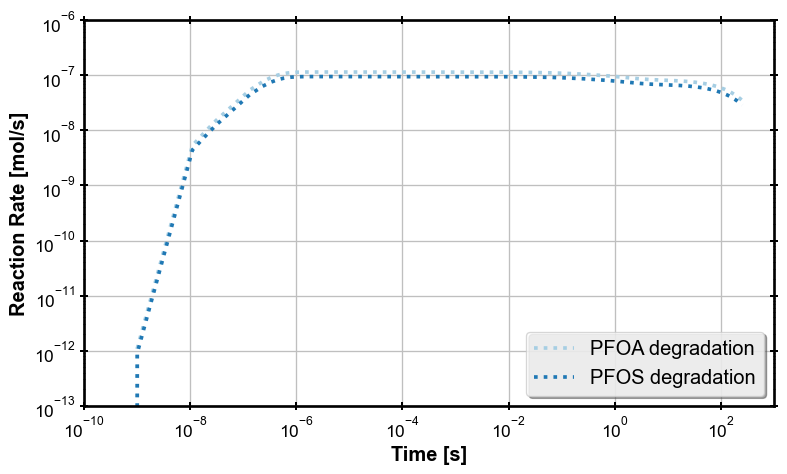

In [222]:
fig_man.set_brewer_map("Paired", "qualitative", 8)
with fig_man.open("Reactions with C7F15COO_minus") as (fig, ax):
    for reaction in res_l.env.reactions_involving_reactant("C7F15COO_minus"):
        ax.plot(dfl.index, dfl[reaction.as_label()],
                label="PFOA degradation",
                marker="",
                linestyle=":",
                linewidth=2.75)
    for reaction in res_l.env.reactions_involving_reactant("C8F17SO3_minus"):
        ax.plot(dfl.index, dfl[reaction.as_label()],
                label="PFOS degradation",
                marker="",
                linestyle=":",
                linewidth=2.75) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Reaction Rate [mol/s]")
    ax.legend()
    
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS")
fig.savefig(root/"PFAS_degradation_rrate_400kGy.png", transparent=True)


## Comparison

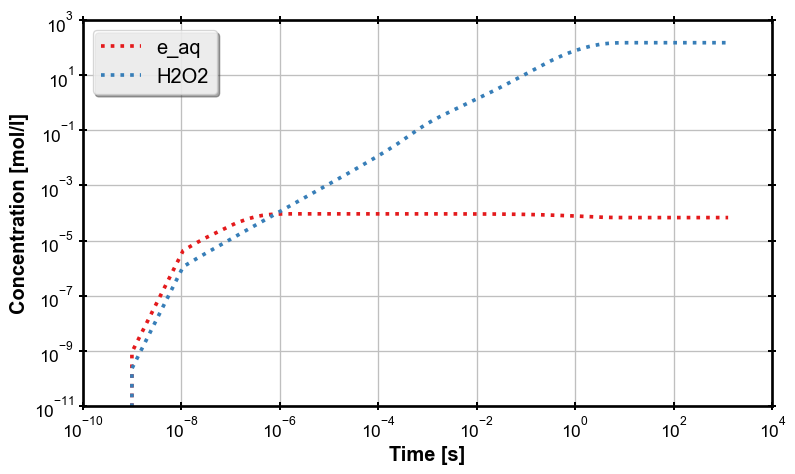

In [233]:
fig_man.set_brewer_map("Set1", "qualitative", 3)
with fig_man.open("CC of e_aq") as (fig, ax):
    ax.plot(res.t, res["e_aq"],
            label="e_aq",
            marker="",
            linestyle=":",
            linewidth=2.75)

    ax.plot(res.t, res["H2O2"],
            label="H2O2",
            marker="",
            linestyle=":",
            linewidth=2.75) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Concentration [µmol/l]")
    ax.legend()
    
root = Path(r"C:\Users\rtonneau\OneDrive - Université de Namur\Documents\PFAS\RESULTS")
fig.savefig(root/"concentration_VS_time_2000kGy.png", transparent=True)
